## Домашнее задание №5

In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

1. Задание:  
    - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
    - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
    - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
    - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
 


In [2]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [4]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [5]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [6]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [7]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [8]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [9]:
# Функция классификации отдельного объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [10]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [11]:
# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [12]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Сформируем с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.

In [13]:
from sklearn.datasets import make_classification
classification_data, classification_labels = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

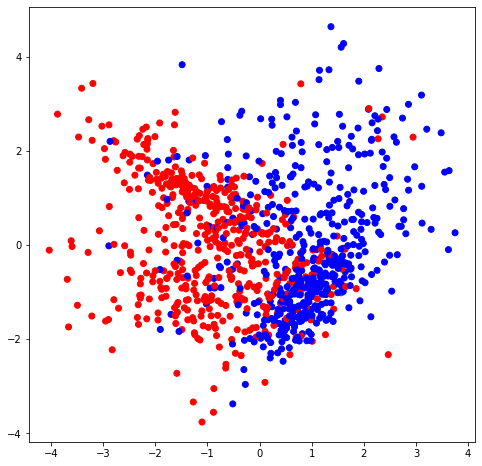

In [14]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [15]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(classification_data, classification_labels, test_size = 0.3, random_state = 1)
X_train.shape, X_test.shape

((700, 2), (300, 2))

In [16]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def show(model, X_train, X_test, y_test, step=0.05, border=1.2):
    #  Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(X_train)

    mesh_predictions = np.array(tree_vote(model, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

    return

In [17]:
trees = [1, 3, 10, 50, 100, 200]

Точность случайного леса из 1 деревьев на обучающей выборке: 90.429
Точность случайного леса из 1 деревьев на тестовой выборке: 68.667


<ipython-input-16-e8ab5f8f9685>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-16-e8ab5f8f9685>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Точность случайного леса из 3 деревьев на обучающей выборке: 95.714
Точность случайного леса из 3 деревьев на тестовой выборке: 77.000
Точность случайного леса из 10 деревьев на обучающей выборке: 99.000
Точность случайного леса из 10 деревьев на тестовой выборке: 78.333
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 79.333
Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 79.667
Точность случайного леса из 200 деревьев на обучающей выборке: 100.000
Точность случайного леса из 200 деревьев на тестовой выборке: 79.333


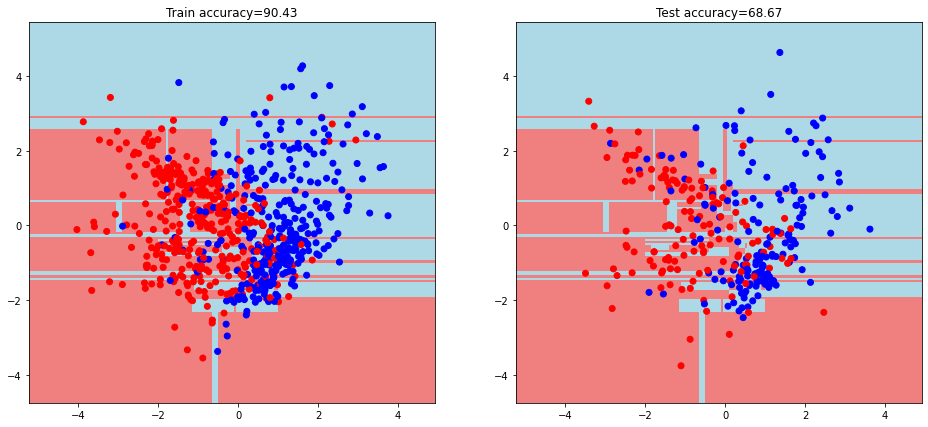

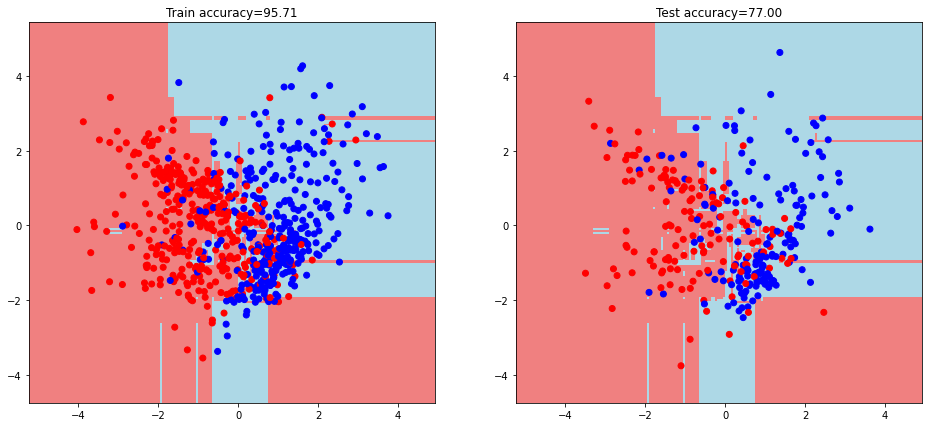

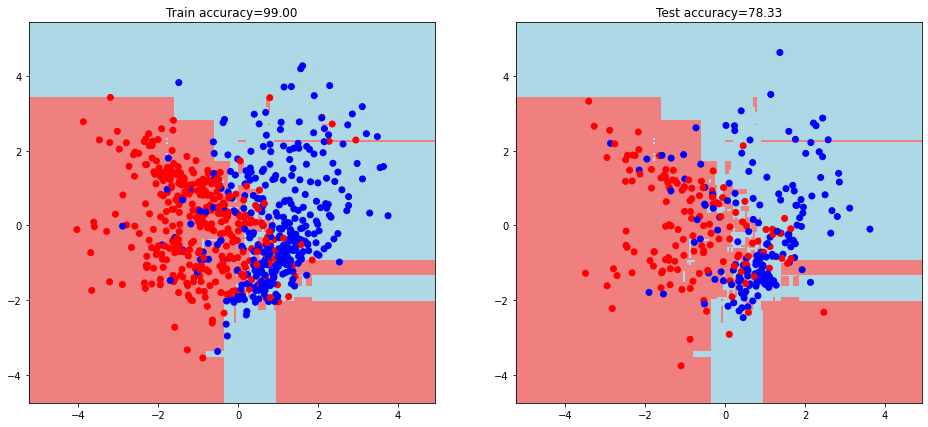

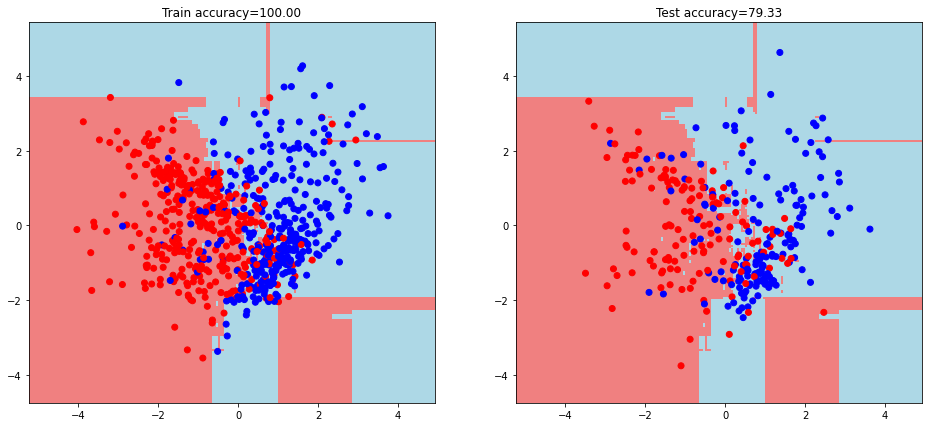

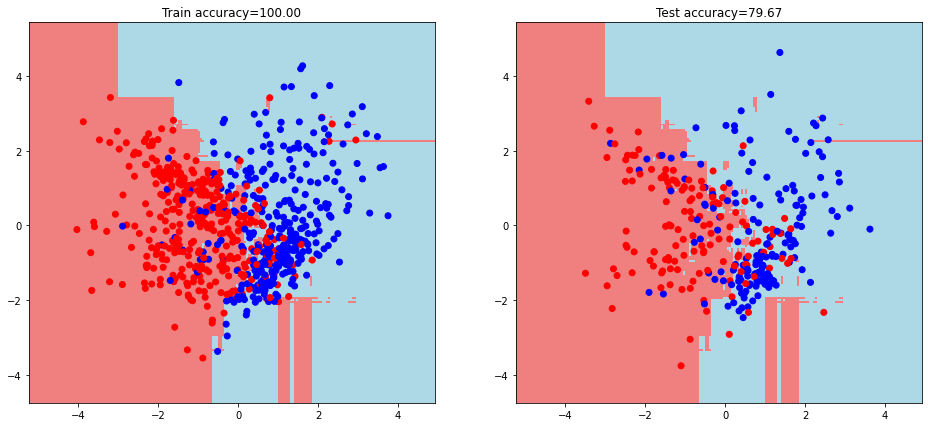

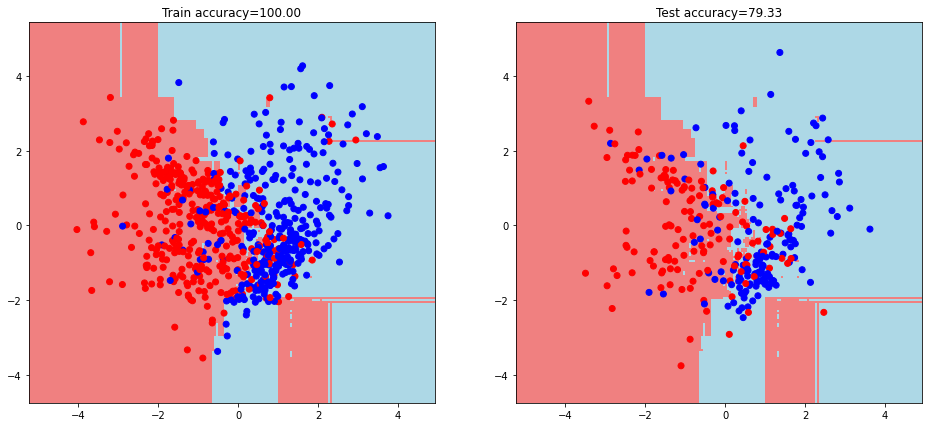

In [18]:
# Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).
for n_trees in trees:
    my_forest = random_forest(X_train, y_train, n_trees)

  # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, X_train)

  # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, X_test)

  # Точность на обучающей выборке
    train_accuracy = accuracy_metric(y_train, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

  # Точность на тестовой выборке
    test_accuracy = accuracy_metric(y_test, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}') 

    show(my_forest, X_train, X_test=X_test, y_test=y_test, step=0.05, border=1.2)

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [19]:
# Точность случайного леса из 1 деревьев на обучающей выборке: 90.429
# Точность случайного леса из 1 деревьев на тестовой выборке: 68.667
# Точность случайного леса из 3 деревьев на обучающей выборке: 95.714
# Точность случайного леса из 3 деревьев на тестовой выборке: 77.000
# Точность случайного леса из 10 деревьев на обучающей выборке: 99.000
# Точность случайного леса из 10 деревьев на тестовой выборке: 78.333
# Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
# Точность случайного леса из 50 деревьев на тестовой выборке: 79.333
# Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
# Точность случайного леса из 100 деревьев на тестовой выборке: 79.667
# Точность случайного леса из 200 деревьев на обучающей выборке: 100.000
# Точность случайного леса из 200 деревьев на тестовой выборке: 79.333

Наилучший результат показала модель из 10 деревьев:
* Точность случайного леса из 10 деревьев на обучающей выборке: 99.000
* Точность случайного леса из 10 деревьев на тестовой выборке: 78.333

При большем количестве деревьев происходит переобучение модели: точность обучающей выборки - 100%, а точность тестовой выборки практически не меняется.

При меньшем количестве деревьев модель не до конца обучена, - точность случайного леса на тестовой выборке не максимальна.